In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

# import numpy as np
# import matplotlib.pyplot as plt
# from pathlib import Path

# import cv2

In [3]:
# Create dataset and dataloader
class CoordinateDataset(Dataset):
    def __init__(self, data_dir):
        self.data = pd.read_csv(data_dir)
        self.x, self.y = self.__processing()

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx] # Se regresa un registro de datos junto con su etiqueta

    def __len__(self):
        return len(self.data)

    def __processing(self):
        i, o = self.data[['x', 'y']].to_numpy(), self.data[['z']].to_numpy()
        return torch.from_numpy(i).float(), torch.from_numpy(o).float()  

PATH_DATASET = 'data/csv/RBS.csv'
dataset = CoordinateDataset(PATH_DATASET)
dataloader = DataLoader(dataset, batch_size=128, shuffle=False) 

for i in dataloader:
    print(i[0].shape)
    break

torch.Size([128, 2])


In [4]:
# Configuration
BATCH_SIZE = 1024
EPOCHS = 100
LEARNING_RATE = 0.001
ROPE_DIM = 128   # Dimension for each coordinate's RoPE embedding
LINEAR_DIM = 256 # Dimension for each linear layer

In [5]:
# def imagenp_open_img(filename:str,BGR2RGB:bool=True) -> np.array:
#     """ Abre una imagen desde un archivo. Soporta caracteres internacionales """
#     f=open(filename,'rb')
#     data=f.read()
#     f.close()
#     data = np.frombuffer(data, np.uint8)
#     img = cv2.imdecode(data,flags=cv2.IMREAD_COLOR)
#     if(BGR2RGB): img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     return img

# def imagenp_show_image(img, figsize=(6,6),title='',normalize01=False, cmap=None):
#     '''Muestra una imagen.
#     image = show_image('../misc/panda.jpg',(15,15))

#     Args:
#         img (str|np.ndarray|PIL.Image.Image): La imagen o ruta del archivo
#         figsize (int,int): Dimensiones de la figura de matplotlib.pyplot
#         title (str): Titulo de la imagen
#         normalize01: Normaliza los datos en el rango [0.0 1.0]
#         cmap: 'gray', 'gray_r', 'Accent', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'Dark2', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'Paired', 'Pastel1', 'Pastel2', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Set1', 'Set2', 'Set3', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'tab10', 'tab20', 'tab20b', 'tab20c', 'terrain', 'winter'
#     '''
#     if isinstance(img,(str|Path)):
#         if not title: title = str(img)
#         img = imagenp_open_img(img,BGR2RGB=True)

#     # if isinstance(img,(PIL.Image.Image)): img = np.array(img)
        
#     original_shape = img.shape
#     original_dtype = img.dtype
#     mini = np.min(img)
#     maxi = np.max(img)
        
#     if img.shape[-1]<3:
#         img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
#     # if len(img.shape)==4: img = imagenp_grid_images(img)
        
#     if normalize01 and maxi > mini: img = (img-mini)/(maxi-mini)
    
#     plt.figure(figsize=figsize)
#     title += f" {original_shape} {original_dtype} {mini:.1f} {maxi:.1f}"
#     plt.title(title)
#     plt.imshow(img, cmap=cmap)
#     plt.axis('off')
#     plt.show()
    
# def imagenp_save_image(filename,img, flipBR=True):
#     '''Guarda una imagen en disco.
#     save_image(img, '../misc/panda.jpg')
#     Args:
#         filename (str): Nombre del archivo donde guardar la imagen
#         img (np.ndarray): La imagen.
#     '''
#     if(flipBR) and (img.shape[-1]==3): img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#     cv2.imwrite(filename,img)

In [6]:
def pt_module_parameters(module):
    """ Retorna la cantidad de parametros del modulo pytorch """
    pp=0
    for p in list(module.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [7]:
# dataset_image = imagenp_open_img("escultura.jpg")
# imagenp_show_image(dataset_image)

In [8]:
# # Create dataset and dataloader
# class CoordinateDataset(Dataset):
#     def __init__(self, image=None):
#         self.height, self.width, _ = (2048,2048,3) if image is None else image.shape #Si image is None, retorna coordenadas de una imagen de 2048x2048x3
#         x_coords = torch.linspace(0, 1, self.width)
#         y_coords = torch.linspace(0, 1, self.height)
#         x_grid, y_grid = torch.meshgrid(x_coords, y_coords, indexing='xy')        
#         self.coords = torch.stack([x_grid.ravel(), y_grid.ravel()], dim=1)
#         self.rgb = None if image is None else torch.from_numpy(image).float().view(-1, 3)/255

#     def __len__(self):
#         return len(self.coords)

#     def __getitem__(self, idx):
#         if self.rgb is None: return self.coords[idx] #Retorna solo coordenadas
#         return self.coords[idx], self.rgb[idx] #Retorna coordenadas e imagen

In [9]:
# dataset = CoordinateDataset(dataset_image)
# dataloader  = DataLoader(dataset,             batch_size=BATCH_SIZE, shuffle=True)   #Coordenadas desordenadas para entrenamiento
# dataloader2 = DataLoader(dataset,             batch_size=BATCH_SIZE, shuffle=False)  #Coordenadas ordenadas para evaluacion
# dataloader3 = DataLoader(CoordinateDataset(), batch_size=BATCH_SIZE, shuffle=False)  #Coordenadas ordenadas para upsampling 2048x2048

In [10]:
# Rotary Position Embedding (RoPE) module
class RoPE(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        inv_freq = torch.logspace(0, 3, dim//2) #Valores que multiplican al angulo van desde 1 a 1000 en escala logaritmica
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, x):
        # x shape: (batch_size, 2) containing (x, y) coordinates
        x_coords = x[:, 0]
        y_coords = x[:, 1]
        
        x_embed = self._embed_single(x_coords)
        y_embed = self._embed_single(y_coords)
        return torch.cat([x_embed, y_embed], dim=1)

    def _embed_single(self, pos):
        # pos shape: (batch_size,)
        angles = pos.unsqueeze(-1) * self.inv_freq.unsqueeze(0)
        sin = torch.sin(angles)
        cos = torch.cos(angles)
        
        # Interleave sin and cos values
        embed = torch.stack([sin, cos], dim=-1)
        return embed.view(embed.size(0), -1)

In [38]:
# Neural network architecture
class ColorNetRope(nn.Module):
    def __init__(self):
        super().__init__()
        self.rope = RoPE(ROPE_DIM)
        self.layers = nn.Sequential(
            nn.Linear(2 * ROPE_DIM, LINEAR_DIM),
            nn.GELU(), 
            nn.Linear(LINEAR_DIM, LINEAR_DIM),
            nn.GELU(),
            nn.Linear(LINEAR_DIM, LINEAR_DIM),
            nn.GELU(),
            nn.Linear(LINEAR_DIM, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.rope(x)
        return self.layers(x)
    
# # Neural network architecture
# class ColorNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(2, LINEAR_DIM),
#             nn.ReLU(),
#             nn.Linear(LINEAR_DIM, LINEAR_DIM),
#             nn.ReLU(),
#             nn.Linear(LINEAR_DIM, LINEAR_DIM),
#             nn.ReLU(),
#             nn.Linear(LINEAR_DIM, 3),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.layers(x)

In [39]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = ColorNet().to(device)
model = ColorNetRope().to(device)
criterion = nn.MSELoss()

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LEARNING_RATE*0.1)

print(f"Model Parameters: {pt_module_parameters(model)}")

Model Parameters: 197633


In [40]:
# train_loss = []
# for epoch in range(EPOCHS):
#     epoch_loss = 0.0
#     for inputs, targets in dataloader:
#         inputs, targets = inputs.to(device), targets.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item() * inputs.size(0)
    
#     scheduler.step()
#     epoch_loss /= len(dataset)
#     train_loss.append(epoch_loss)
#     print(f'Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.6f} LR: {scheduler.get_last_lr()[0]:.6f}')

In [41]:
# Training loop
train_loss = []
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False)
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix(loss=loss.item(), lr=scheduler.get_last_lr()[0])
    scheduler.step()
    epoch_loss /= len(dataset)
    train_loss.append(epoch_loss)
    print(f'Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.6f} LR: {scheduler.get_last_lr()[0]:.6f}')

Epoch 1/100 - Loss: 0.001303 LR: 0.001000


Epoch 2/100 - Loss: 0.000612 LR: 0.000999


Epoch 3/100 - Loss: 0.000537 LR: 0.000998


Epoch 4/100 - Loss: 0.000487 LR: 0.000996


Epoch 5/100 - Loss: 0.000451 LR: 0.000994


Epoch 6/100 - Loss: 0.000420 LR: 0.000992


Epoch 7/100 - Loss: 0.000389 LR: 0.000989


Epoch 8/100 - Loss: 0.000359 LR: 0.000986


Epoch 9/100 - Loss: 0.000332 LR: 0.000982


Epoch 10/100 - Loss: 0.000311 LR: 0.000978


Epoch 11/100 - Loss: 0.000292 LR: 0.000973


Epoch 12/100 - Loss: 0.000275 LR: 0.000968


Epoch 13/100 - Loss: 0.000264 LR: 0.000963


Epoch 14/100 - Loss: 0.000254 LR: 0.000957


Epoch 15/100 - Loss: 0.000254 LR: 0.000951


Epoch 16/100 - Loss: 0.000253 LR: 0.000944


Epoch 17/100 - Loss: 0.000238 LR: 0.000937


Epoch 18/100 - Loss: 0.000225 LR: 0.000930


Epoch 19/100 - Loss: 0.000216 LR: 0.000922


Epoch 20/100 - Loss: 0.000203 LR: 0.000914


Epoch 21/100 - Loss: 0.000199 LR: 0.000906


Epoch 22/100 - Loss: 0.000196 LR: 0.000897


Epoch 23/100 - Loss: 0.000193 LR: 0.000888


Epoch 24/100 - Loss: 0.000188 LR: 0.000878


Epoch 25/100 - Loss: 0.000179 LR: 0.000868


Epoch 26/100 - Loss: 0.000174 LR: 0.000858


Epoch 27/100 - Loss: 0.000167 LR: 0.000848


Epoch 28/100 - Loss: 0.000158 LR: 0.000837


Epoch 29/100 - Loss: 0.000156 LR: 0.000826


Epoch 30/100 - Loss: 0.000150 LR: 0.000815


Epoch 31/100 - Loss: 0.000142 LR: 0.000803


Epoch 32/100 - Loss: 0.000137 LR: 0.000791


Epoch 33/100 - Loss: 0.000132 LR: 0.000779


Epoch 34/100 - Loss: 0.000126 LR: 0.000767


Epoch 35/100 - Loss: 0.000127 LR: 0.000754


Epoch 36/100 - Loss: 0.000116 LR: 0.000742


Epoch 37/100 - Loss: 0.000111 LR: 0.000729


Epoch 38/100 - Loss: 0.000113 LR: 0.000716


Epoch 39/100 - Loss: 0.000110 LR: 0.000702


Epoch 40/100 - Loss: 0.000108 LR: 0.000689


Epoch 41/100 - Loss: 0.000109 LR: 0.000676


Epoch 42/100 - Loss: 0.000116 LR: 0.000662


Epoch 43/100 - Loss: 0.000101 LR: 0.000648


Epoch 44/100 - Loss: 0.000095 LR: 0.000634


Epoch 45/100 - Loss: 0.000094 LR: 0.000620


Epoch 46/100 - Loss: 0.000093 LR: 0.000606


Epoch 47/100 - Loss: 0.000092 LR: 0.000592


Epoch 48/100 - Loss: 0.000091 LR: 0.000578


Epoch 49/100 - Loss: 0.000088 LR: 0.000564


Epoch 50/100 - Loss: 0.000085 LR: 0.000550


Epoch 51/100 - Loss: 0.000082 LR: 0.000536


Epoch 52/100 - Loss: 0.000080 LR: 0.000522


Epoch 53/100 - Loss: 0.000080 LR: 0.000508


Epoch 54/100 - Loss: 0.000075 LR: 0.000494


Epoch 55/100 - Loss: 0.000074 LR: 0.000480


Epoch 56/100 - Loss: 0.000071 LR: 0.000466


Epoch 57/100 - Loss: 0.000068 LR: 0.000452


Epoch 58/100 - Loss: 0.000068 LR: 0.000438


Epoch 59/100 - Loss: 0.000066 LR: 0.000424


Epoch 60/100 - Loss: 0.000066 LR: 0.000411


Epoch 61/100 - Loss: 0.000063 LR: 0.000398


Epoch 62/100 - Loss: 0.000060 LR: 0.000384


Epoch 63/100 - Loss: 0.000059 LR: 0.000371


Epoch 64/100 - Loss: 0.000061 LR: 0.000358


Epoch 65/100 - Loss: 0.000058 LR: 0.000346


Epoch 66/100 - Loss: 0.000054 LR: 0.000333


Epoch 67/100 - Loss: 0.000053 LR: 0.000321


Epoch 68/100 - Loss: 0.000050 LR: 0.000309


Epoch 69/100 - Loss: 0.000048 LR: 0.000297


Epoch 70/100 - Loss: 0.000047 LR: 0.000285


Epoch 71/100 - Loss: 0.000047 LR: 0.000274


Epoch 72/100 - Loss: 0.000046 LR: 0.000263


Epoch 73/100 - Loss: 0.000045 LR: 0.000252


Epoch 74/100 - Loss: 0.000043 LR: 0.000242


Epoch 75/100 - Loss: 0.000042 LR: 0.000232


Epoch 76/100 - Loss: 0.000041 LR: 0.000222


Epoch 77/100 - Loss: 0.000040 LR: 0.000212


Epoch 78/100 - Loss: 0.000039 LR: 0.000203


Epoch 79/100 - Loss: 0.000038 LR: 0.000194


Epoch 80/100 - Loss: 0.000037 LR: 0.000186


Epoch 81/100 - Loss: 0.000036 LR: 0.000178


Epoch 82/100 - Loss: 0.000035 LR: 0.000170


Epoch 83/100 - Loss: 0.000035 LR: 0.000163


Epoch 84/100 - Loss: 0.000034 LR: 0.000156


Epoch 85/100 - Loss: 0.000033 LR: 0.000149


Epoch 86/100 - Loss: 0.000032 LR: 0.000143


Epoch 87/100 - Loss: 0.000032 LR: 0.000137


Epoch 88/100 - Loss: 0.000031 LR: 0.000132


Epoch 89/100 - Loss: 0.000030 LR: 0.000127


Epoch 90/100 - Loss: 0.000029 LR: 0.000122


Epoch 91/100 - Loss: 0.000029 LR: 0.000118


Epoch 92/100 - Loss: 0.000028 LR: 0.000114


Epoch 93/100 - Loss: 0.000028 LR: 0.000111


Epoch 94/100 - Loss: 0.000028 LR: 0.000108


Epoch 95/100 - Loss: 0.000028 LR: 0.000106


Epoch 96/100 - Loss: 0.000027 LR: 0.000104


Epoch 97/100 - Loss: 0.000026 LR: 0.000102


Epoch 98/100 - Loss: 0.000026 LR: 0.000101


Epoch 99/100 - Loss: 0.000026 LR: 0.000100


Epoch 100/100 - Loss: 0.000025 LR: 0.000100


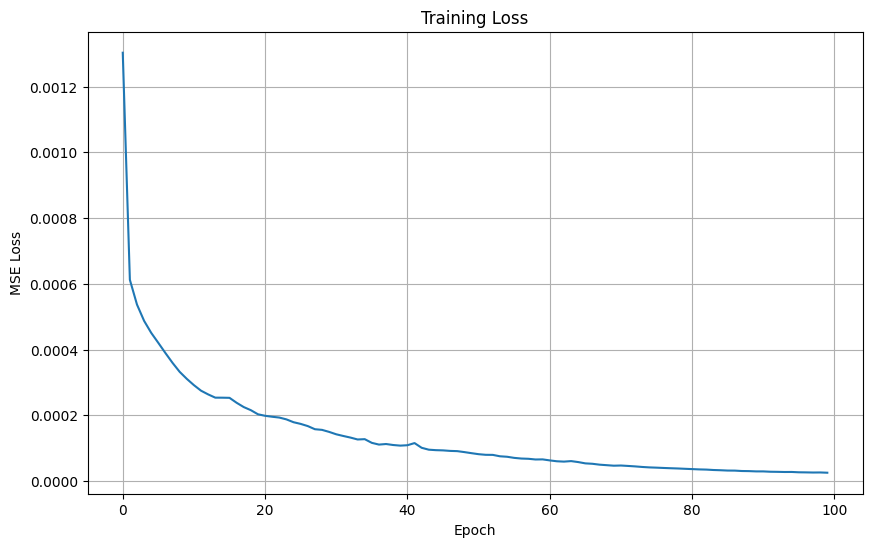

In [42]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np


x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
x, y = np.meshgrid(x, y)

input = np.c_[x.ravel(), y.ravel()] 
input = torch.tensor(input, dtype=torch.float32).to(device)

z = model(input).cpu().detach().numpy().reshape(x.shape)

#plot z 
plt.figure(figsize=(10, 6))
plt.contourf(x, y, z, cmap='viridis')
plt.colorbar()
plt.title('Predicted Surface')
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 23.84 GiB. GPU 0 has a total capacity of 23.63 GiB of which 21.13 GiB is free. Process 856391 has 471.80 MiB memory in use. Including non-PyTorch memory, this process has 1.43 GiB memory in use. Of the allocated memory 783.73 MiB is allocated by PyTorch, and 220.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

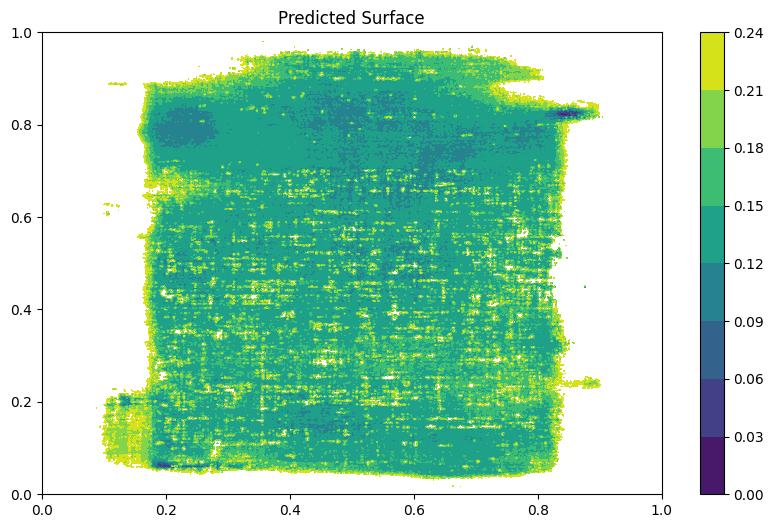

In [97]:
# join x,y, z and filter points where z < plane_water
plane_water = 0.2714322665492493 - 0.05

mask = z < plane_water
z_filtered = np.where(mask, z, np.nan)


plt.figure(figsize=(10, 6))
plt.contourf(x, y, z_filtered, cmap='viridis')
plt.colorbar()
plt.title('Predicted Surface')
plt.show()

In [44]:
# # Calculate final metrics
# with torch.no_grad():
#     model.eval()
#     all_outputs = []
#     all_targets = []
    
#     for inputs, targets in dataloader2:
#         inputs = inputs.to(device)
#         outputs = model(inputs)
#         all_outputs.append(outputs.cpu())
#         all_targets.append(targets.cpu())
    
#     outputs = torch.cat(all_outputs)
#     targets = torch.cat(all_targets)
    
#     # Calculate MSE and PSNR
#     mse = criterion(outputs, targets)
#     psnr = 20 * torch.log10(torch.tensor(1.0)) - 10 * torch.log10(mse)
    
#     print(f'\nFinal Metrics:')
#     print(f'MSE: {mse.item():.6f}')
#     print(f'PSNR: {psnr.item():.2f} dB')



In [45]:
# # Visualize results
# with torch.no_grad():
#     predicted_image = outputs.view(dataset_image.shape[-3], dataset_image.shape[-2], dataset_image.shape[-1]).numpy()

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(dataset_image)
# ax[0].set_title('Original Image')
# ax[1].imshow(predicted_image)
# ax[1].set_title('Predicted Image')
# plt.show()

In [46]:
# # Calculate final metrics
# with torch.no_grad():
#     model.eval()
#     all_2k = []
    
#     for inputs in dataloader3:
#         inputs = inputs.to(device)
#         outputs = model(inputs)
#         all_2k.append(outputs.cpu())
    
#     outputs = torch.cat(all_2k)
#     predicted_image = outputs.view(2048, 2048, 3).numpy()
    
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(dataset_image)
# ax[0].set_title('Original Image')
# ax[1].imshow(predicted_image)
# ax[1].set_title('Upscaled Image')
# plt.show()
    
    